In [28]:
# https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split, cross_val_score

from xgboost import XGBRegressor, plot_tree, plot_importance

############################################
import itertools
############################################


data_path = 'C:/Users/mkshi/Documents/Kaggle_projects/house_proces_advanced/'

In [2]:
# load data
df = pd.read_csv(os.path.join(data_path,'train.csv'))
print(df.shape)
df.head(3)

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [4]:
# df.info()

In [5]:
# Drop ID
df.drop('Id',axis=1, inplace=True)

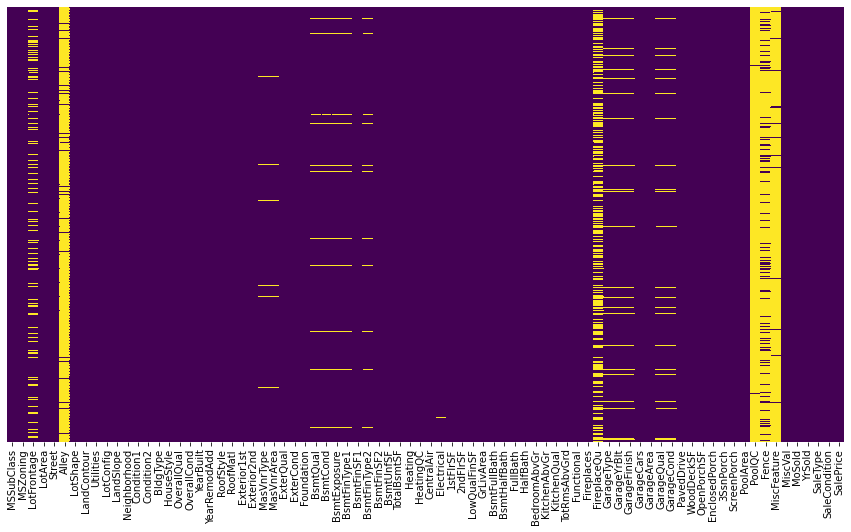

In [6]:
# Get a sense of how many missing values are in the data
# plot heatmap for detecting null values
plt.figure(figsize=(15,8))
sns.heatmap(df.isnull(),cmap="viridis",yticklabels=False,cbar=False);

In [7]:
# Drop features that have over n values missing
n = 0.15
features_with_many_missing_values = [i for i in df.columns if df[i].isnull().sum()>len(df)*n]
df.drop(features_with_many_missing_values,axis=1, inplace=True)
df.shape

(1460, 74)

In [8]:
# Go over the features and manually change categorical values of an ordinal-scale to numerical values
# link to data description: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

def ordinal_from_categorical_to_numeric(df):
    df['Utilities'].replace({'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}, inplace=True)
    df['LandSlope'].replace({'Gtl':1, 'Mod':2, 'Sev':3}, inplace=True)
    df['ExterQual'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
    df['ExterCond'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
    df['BsmtQual'].replace({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True) # rethink: NA could be as good as poor quality
    df['BsmtCond'].replace({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
    df['BsmtExposure'].replace({'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}, inplace=True)
    df['BsmtFinType1'].replace({'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)
    df['BsmtFinType2'].replace({'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)
    df['HeatingQC'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
    df['CentralAir'].replace({'N':0, 'Y':1}, inplace=True)
    df['KitchenQual'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
    df['GarageFinish'].replace({'NA':0, 'Unf':1, 'RFn':2, 'Fin':3}, inplace=True)
    df['GarageQual'].replace({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
    df['GarageCond'].replace({'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
    df['PavedDrive'].replace({'N':1, 'P':2, 'Y':3}, inplace=True)
    
    return df

df = ordinal_from_categorical_to_numeric(df)
print(df.shape)

# # Additional manual sanity-checks
# if sum(df['YearBuilt']<=df['YearRemodAdd']) < len(df):
#     raise Exception(len(df)-sum(df['YearBuilt']<=df['YearRemodAdd']), ' houses were remodeled before being built, see YearBuilt and YearRemodAdd')
    
    
# Manually scatter and/or check details, if needed:
# sns.scatterplot(x=df['****'], y='SalePrice',data=df_temp, legend=True)
# df[['PavedDrive']].describe()


(1460, 74)


In [9]:
# deal with missing values
features_that_have_nulls = [i for i in df.columns if df[i].isnull().sum()>0]
corrMatrix = df.corr()
for i in features_that_have_nulls:
    if (df[i].dtype == np.int64) or (df[i].dtype == np.float64):
        # find the column that best correlates with the column that has missing values
        best_corr = corrMatrix[[i]].nlargest(2,[i]).transpose().columns[1] #take the 2nd best (the #1 best corr will be with itself)
        df[i] = df[i].fillna(df.groupby(best_corr)[i].transform('mean'))
    else:
        # for categorical features, fill in with the common value
        df[i].fillna(df[i].value_counts().index[0], inplace=True)
        
print(df.shape)

(1460, 74)


In [10]:
# convert categorical variables to dummy variables
df = pd.get_dummies(df)
df.head()
print(df.shape)

(1460, 221)


In [11]:
# Normalize (min-max normalization)
normalized_df=(df-df.min())/(df.max()-df.min())

In [12]:
# Drop featuers with very low variance (where 1 value constitutes over n% of the data)
n = 98 # %
features_with_low_variance = [i for i in df.columns if df.groupby(i).count().max()[0] > n/100*len(df)]
df.drop(features_with_low_variance,axis=1, inplace=True)
df.shape

(1460, 128)

#### * Done preprocessing *

## Modeling

In [13]:
# Split train and test sets - though I don't need to, I have a test set and I get the sccore from the Kaggle site....
y = df['SalePrice']
X = df.drop(['SalePrice'],1)
# random split to train (70%), validation (15%) and self-test (15%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

Training score:  0.9751270919941132 
10-fold cross validation mean score:  0.8425199271811726


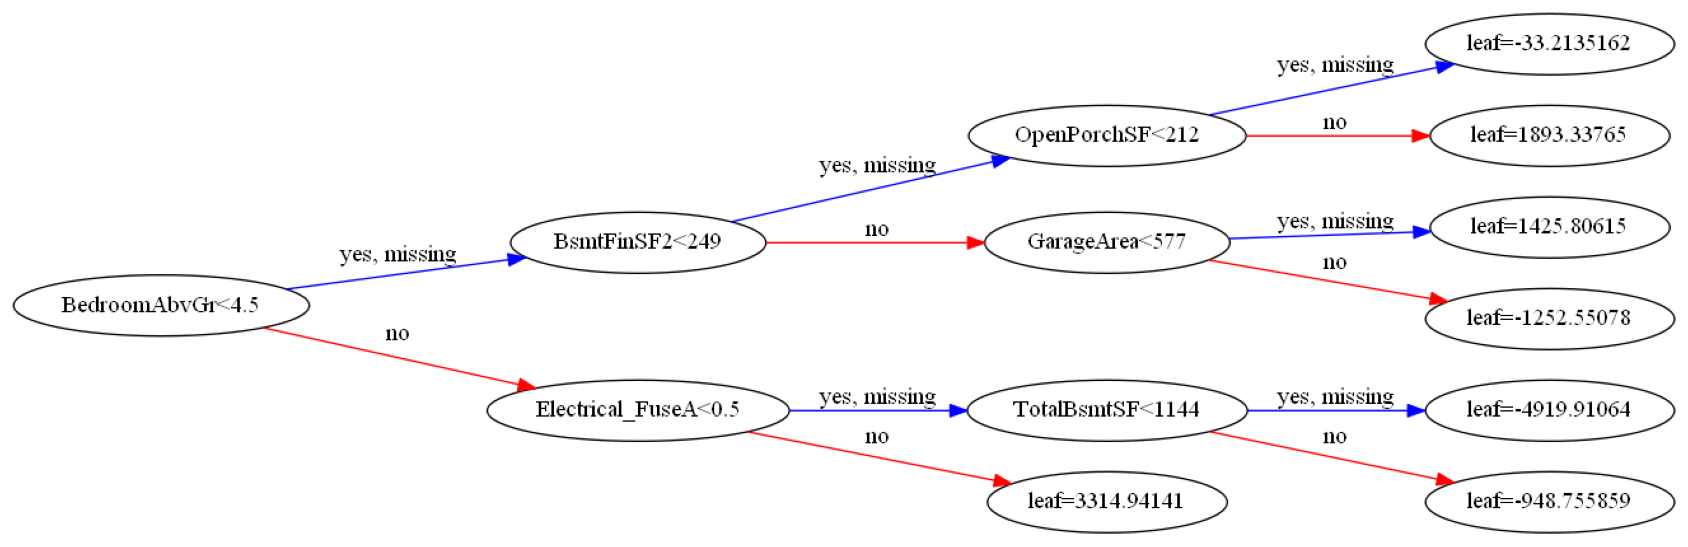

In [32]:
# XGBoosting
xg_model = XGBRegressor(n_estimators=70, max_depth=3, learning_rate=0.25, subsample=0.8)
xg_model.fit(X_train, y_train)

# Test the model's training and cross validation score
cv_scores = cross_val_score(xg_model, X_train, y_train, cv=10)
train_score = xg_model.score(X_train, y_train)
print('Training score: ', train_score ,'\n10-fold cross validation mean score: ', cv_scores.mean())

# Visualize single DTs to gain some insight into the boosting process:
plot_tree(xg_model, num_trees=50, rankdir='LR') # note: num_trees is the ordinal number of the tree plotted
fig = plt.gcf()
fig.set_size_inches(30, 30)

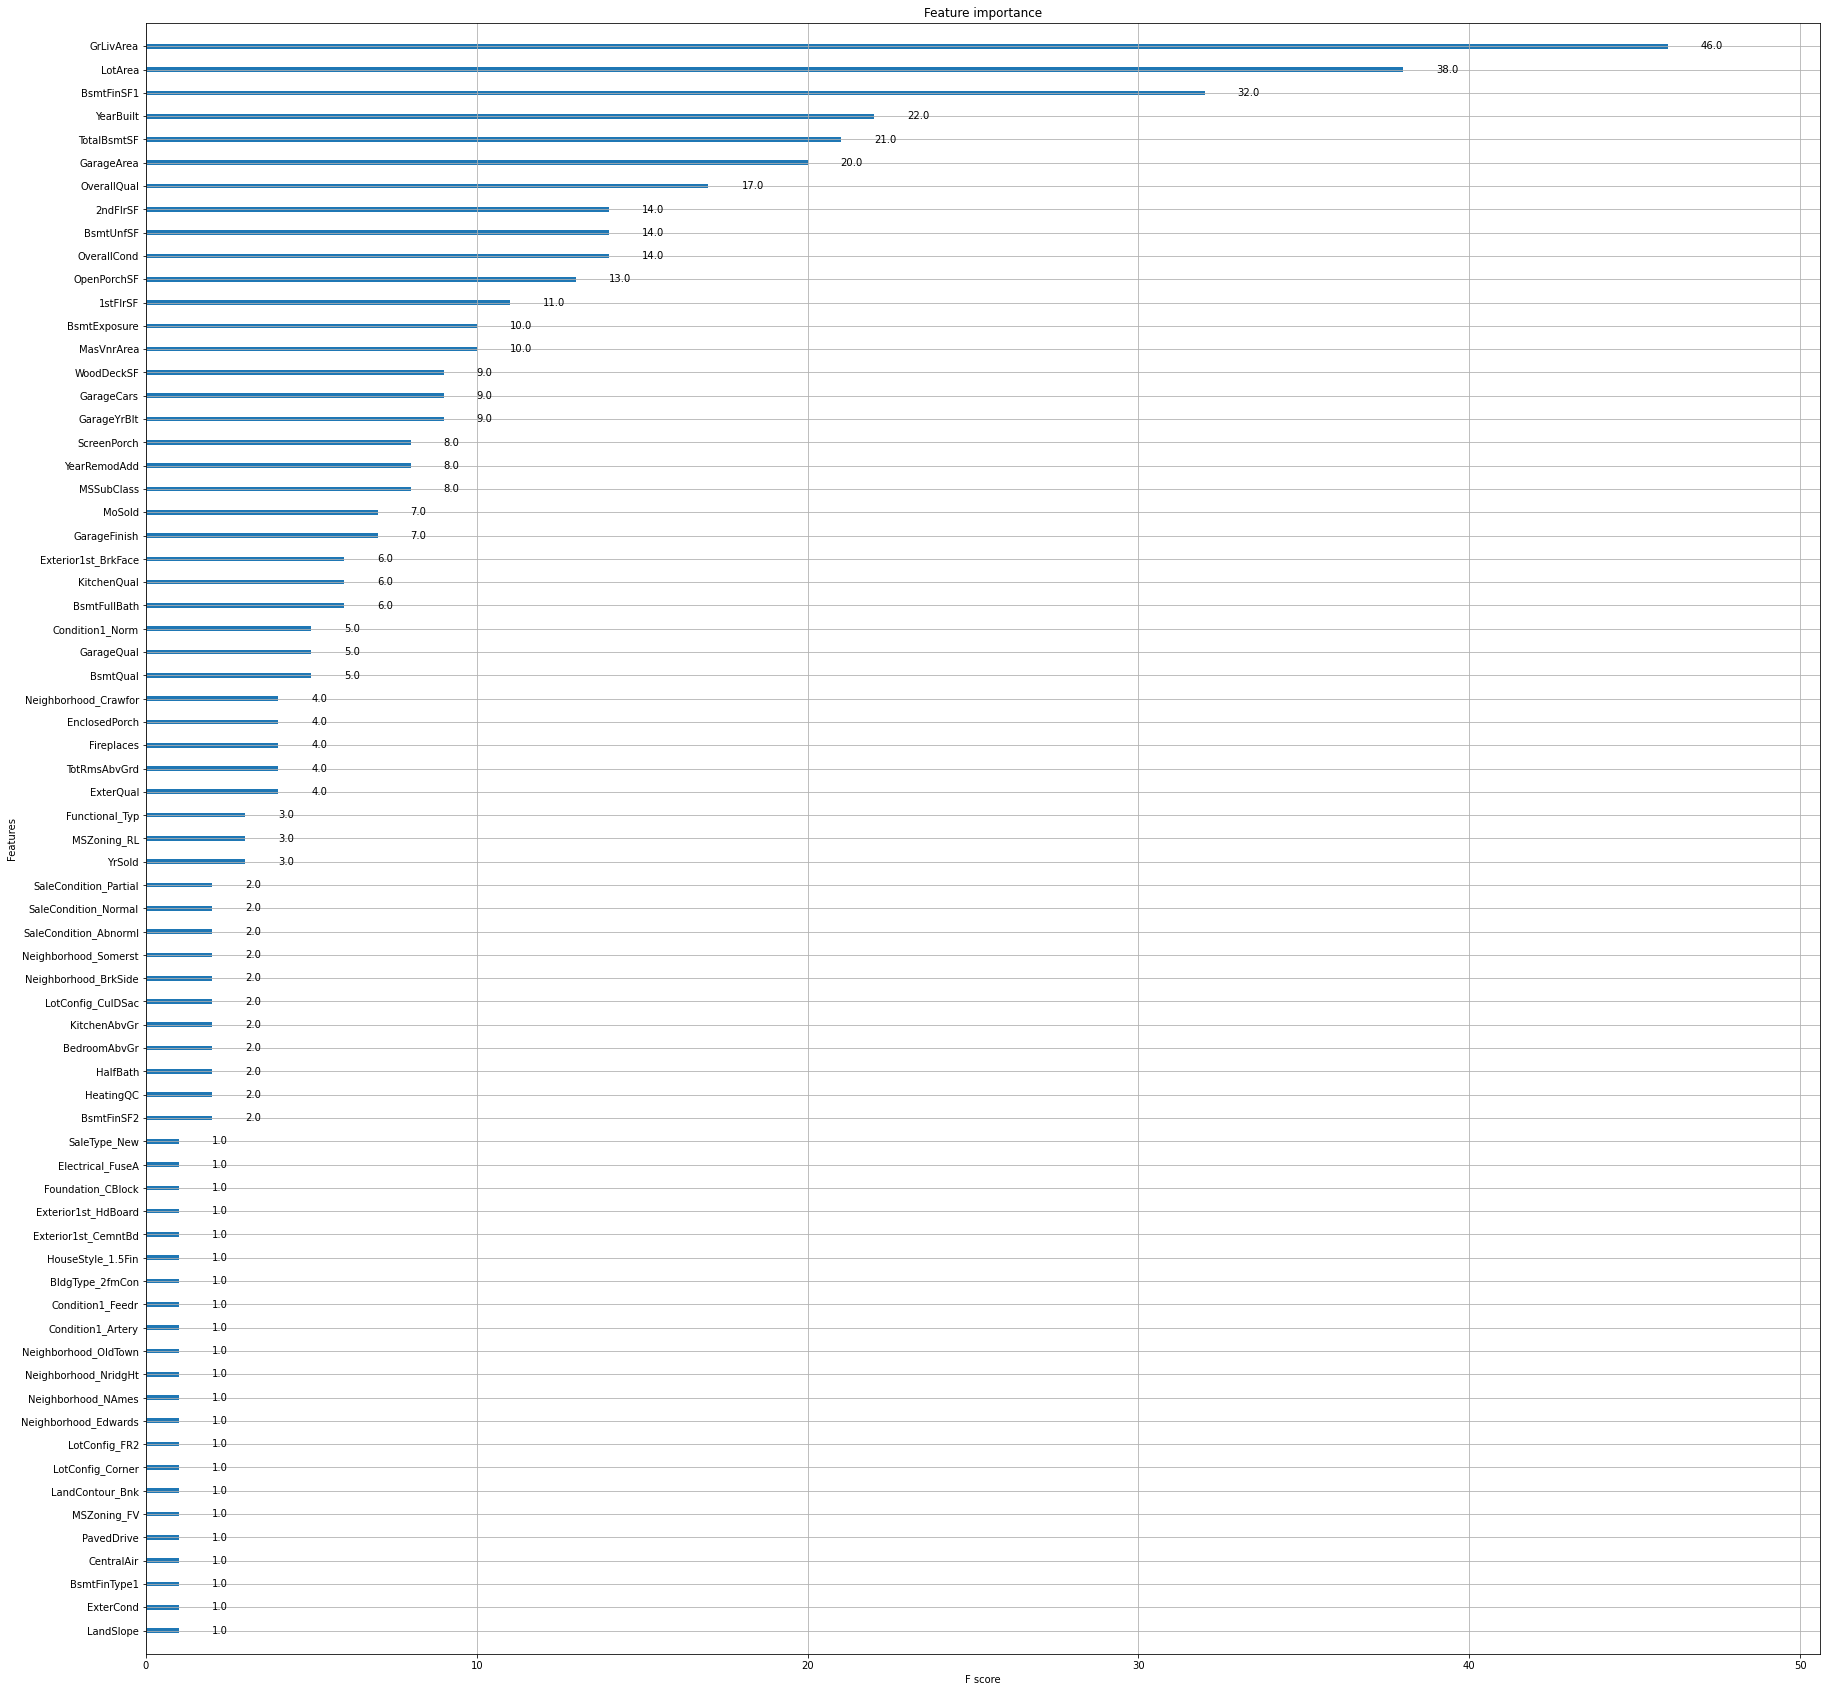

In [34]:
plot_importance(xg_model)
fig = plt.gcf()
fig.set_size_inches(30, 30)

feature_importance = np.sort(xg_model.feature_importances_)



In [ ]:
# from sklearn.model_selection import validation_curve

# # Optimize hyperparameters
# param_to_optimize = 'max_depth'


# param_range = np.arange(2,40,1)
# train_scores, cv_scores = validation_curve(
#     XGBRegressor(n_estimators=70, learning_rate=0.25, subsample=0.8), 
#     X_train, y_train,
#     param_name=param_to_optimize, param_range=param_range, 
#     scoring='neg_mean_squared_error', n_jobs=2)
# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# cv_scores_mean = np.mean(cv_scores, axis=1)
# cv_scores_std = np.std(cv_scores, axis=1)

# # plot
# plt.title('Validation Curve with XGBoosting')
# plt.xlabel(param_to_optimize)
# plt.ylabel("Score")
# # plt.ylim(0.0, 1.1)
# lw = 2
# plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
# plt.fill_between(param_range,
#     train_scores_mean - train_scores_std,
#     train_scores_mean + train_scores_std,
#     alpha=0.2, color="darkorange", lw=lw)
# plt.plot(param_range, cv_scores_mean, label="Cross-validation score", color="navy", lw=lw)
# plt.fill_between(param_range, 
#     cv_scores_mean - cv_scores_std,
#     cv_scores_mean + cv_scores_std,
#     alpha=0.2, color="navy", lw=lw)
# plt.legend(loc="best")
# plt.show()

In [25]:
# Optimize features according to their importance

plot_importance(xg_model)
fig = plt.gcf()
fig.set_size_inches(30, 30)

feature_importance = sort(xg_model.feature_importances_)

### Prepare test data for prediction

In [19]:
# load the data
df_test = pd.read_csv(os.path.join(data_path,'test.csv'))
print(df_test.shape)
# df_test.info()

df_test = ordinal_from_categorical_to_numeric(df_test)
# df_test.info()
Id = df_test[['Id']]
df_test.drop(['Id',*features_with_many_missing_values] ,axis=1, inplace=True)
print(df_test.shape)

# deal with missing values
features_that_have_nulls = [i for i in df.columns if df[i].isnull().sum()>0]
corrMatrix = df.corr()
for i in features_that_have_nulls:
    if (df[i].dtype == np.int64) or (df[i].dtype == np.float64):
        # find the column that best correlates with the column that has missing values
        best_corr = corrMatrix[[i]].nlargest(2,[i]).transpose().columns[1] #take the 2nd best (the #1 best corr will be with itself)
        df[i] = df[i].fillna(df.groupby(best_corr)[i].transform('mean'))
    else:
        # for categorical features, fill in with the common value
        df[i].fillna(df[i].value_counts().index[0], inplace=True)

df_test = pd.get_dummies(df_test)
print(df_test.shape)        

# Drop unwanted features
df_test.drop(features_with_low_variance ,axis=1, inplace=True, errors='ignore')
print(df_test.shape)


(1459, 80)
(1459, 73)
(1459, 206)
(1459, 127)


In [20]:
# Predict test data
test_predictions = xg_model.predict(df_test)
# save in submission format
results = Id.assign(SalePrice = test_predictions) # assign predictions to Id
results.to_csv(os.path.join(data_path,'submission.csv'), index=False) # write the final dataset to a csv file.
